In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex4 import *

/tmp/ipykernel_18/1500229236.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2024-03-24 12:31:42.958045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 12:31:42.958236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 12:31:43.140470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

Minimum Validation Loss: 0.1914


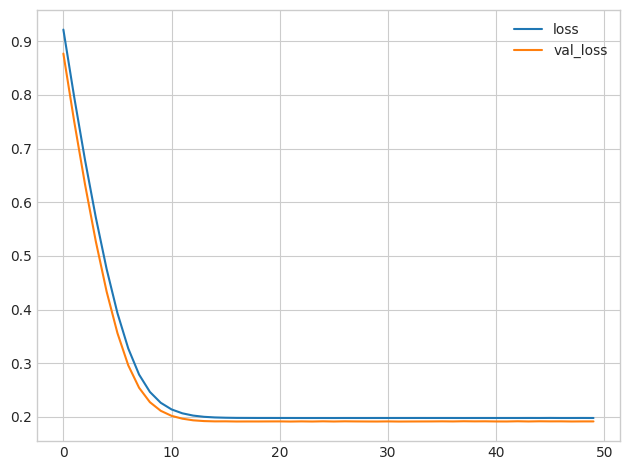

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1914


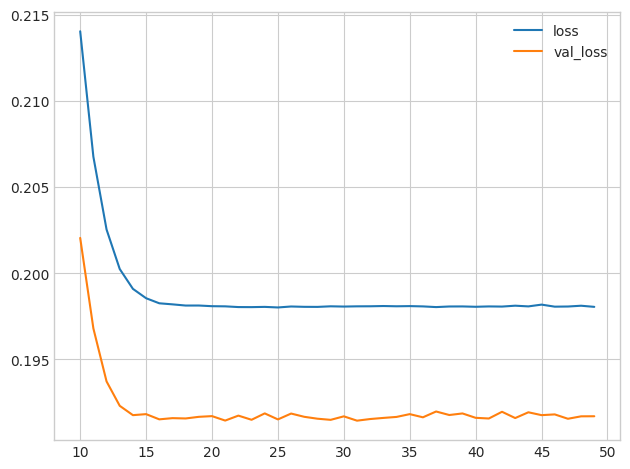

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Epoch 1/50
50/50 [==============================] - 1s 9ms/step - loss: 0.2319 - val_loss: 0.2015
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2018 - val_loss: 0.1979
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1971 - val_loss: 0.1964
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1941 - val_loss: 0.1974
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1917 - val_loss: 0.1935
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1903 - val_loss: 0.1953
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1894 - val_loss: 0.1950
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1886 - val_loss: 0.1944
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.1871 - val_loss: 0.1933
Epoch 10/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1862 - val_loss: 0.1936
Epoch 11/50
50/50 [

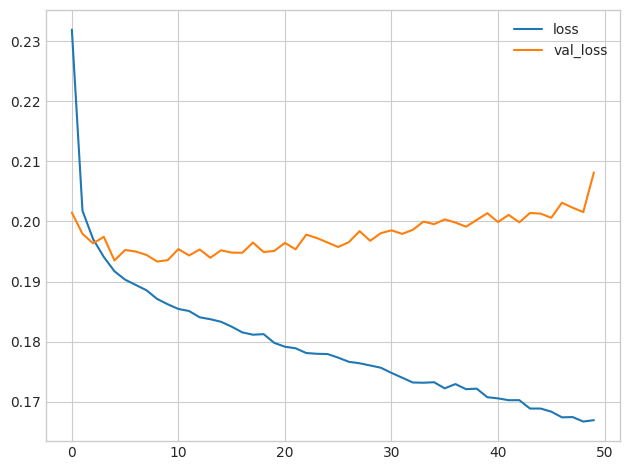

In [6]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [8]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Epoch 1/50
50/50 [==============================] - 1s 10ms/step - loss: 0.2265 - val_loss: 0.2023
Epoch 2/50
50/50 [==============================] - 0s 6ms/step - loss: 0.2002 - val_loss: 0.1971
Epoch 3/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1956 - val_loss: 0.1958
Epoch 4/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1937 - val_loss: 0.1977
Epoch 5/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1918 - val_loss: 0.1974
Epoch 6/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1899 - val_loss: 0.1955
Epoch 7/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1887 - val_loss: 0.1947
Epoch 8/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1873 - val_loss: 0.1950
Epoch 9/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1869 - val_loss: 0.1964
Epoch 10/50
50/50 [==============================] - 0s 6ms/step - loss: 0.1856 - val_loss: 0.1983
Epoch 11/50
50/50 

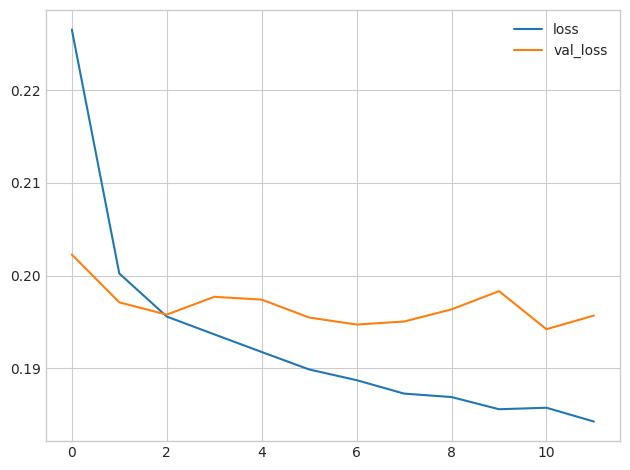

In [10]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));